In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import (linear_model, preprocessing, neural_network, pipeline, model_selection)
import tensorflow as tf

Given the limited time I had access to Bloomberg I will first carry on with data exploration in 6 of the 24 nations I have planed. I only focus on the two ends of the yield curve for now, the 3 month and 10 year, and I will treat **USD United States of America (Developped Economy)** as the domestic country this is done to stay in line with the previous literature (Cerutti et al., 2019; Du et al., 2018; Avdjiev et al., 2017; Liao, 2016; Rime et al., 2017; Hong et al.,2019). 

The nations are:  
**KRW South Korea** (Emerging Economy)  
**INR India** (Emerging Economy)  
**MXN Mexico**  (Emerging Economy)    
**EUR Eurozone** (Developped Economy)   
**JPY Japan**  (Developped Economy)     
**AUD Australia**  (Developped Economy) 

## Data

I sourced interest rate, spot exchange rate, and forward rates from Bloomberg using the functions and securities from the following table

|         | 1,5,10 Year Rates | 3 Month Rates | 1 Month Rates | Forward Rates | Spot Rates |
|---------|-------------------|---------------|---------------|---------------|------------|
| **KRW** | GTKRW*x*          | KWDRC         | KWDRA         | KWN+*x*       | KRWUSD     |
| **INR** | GIND*x*           | IRDRC         | IRDRA         | IRN+*x*       | INRUSD     |
| **MXN** | GTMXN*x*          | MPDRC         | MPDRA         | MXN*x*        | MXNUSD     |
| **EUR** | GTEUR*x*          | EURRC         | EURRA         | EUR*x*        | EURUSD     |
| **JPY** | GTJPY*x*          | JPYRC         | JPYRA         | JPY*x*        | JPYUSD     |
| **AUD** | GTAUD*x*          | AUDRC         | AUDRA         | AUD*x*        | AUDUSD     |
| **USD** | GT*x*             | USDRC         | USDRA         | -             | -          |

where *x* is the time horizon (i.e 5Y)

The definition of each function is as follows: 

- GT*: Generic Government Treasury Fixed Income Asset (i.e bonds, bills, notes)
- *RC: The annualized rate of interest that a bank will charge for lending or pay for borrowing a currency for a specific tenor for 3 months.
- *RA: The annualized rate of interest that a bank will charge for lending or pay for borrowing a currency for a specific tenor for 1 month.
- *+*x*: Non-deliverable forwards are a type of cash settled financial derivative. In the foreign exchange  market, traders and investors will enter into an outright forward
- **x*: Forward points    
  
where * denotes the currencies (i.e USD) and *x* is still time horizon (i.e 5Y)

In [150]:
#Define a function that checks for missing values
def check_missing(df,date = "2005-01-03"):
    #This function takes in a dataframe and goes
    #through the columns to check for missing values
    for i in range(1,len(list(df.columns.values))):
        if df.isnull().all()[i]:
            print(df.columns[i] + " has no values")
        else:
            first_value_index = df.notna().idxmax()[i]
            if str(df.iloc[first_value_index,0]) != date:
                print("First non-null value in "+ df.columns[i] + " starts on",df.iloc[first_value_index,0])       
            
#Define a function that turns a string to a date
def to_date(df):
    #This function takes in a dataframe and
    #changes the Date column from str to datetime
    df["Date"] = pd.to_datetime(df["Date"]).dt.date
    
#Define a function that changes the % rate to decimal rates
def to_rate(df):
    df[df.columns[1:]] = df[df.columns[1:]]/100
    
#Define a function that calculates the deviation from CIP
def cip(df,currency,horizon):
    #Calculate artificial yield by forward/spot*(1+foreign yield) - 1
    #Furthermore forward = spot + forward basis/100 so 
    #forward/spot = 1 + forward basis/100*spot then Calculate deviation
    #from CIP as x = US yield - artificial yield
    forward = currency+horizon
    foreign_rate = horizon+currency
    df["ArtYield"] = ((1+(df[forward]/(100*df[currency])))*(1+df[foreign_rate])) - 1
    df["Deviation"] = (df[horizon+"USD"] - df["ArtYield"])*100

#Define a function that plots the plots the deviation from CIP
def plot_cip(df):
    #Takes the data frame and plots the data
    
    #Calculate deviation from CIP as x = US yield - artificial yield
    cip(df,currency,horizon)

    #Find the min and max x values
    min_x = df.iloc[df[["Deviation"]].notna().idxmax(),0]
    max_x = df["Date"].tail(1)

    #Plot figure
    fig, ax = plt.subplots(figsize=(15,6))
    df.plot(x="Date",y="Deviation", ax=ax,legend=False).hlines(0,min_x,max_x,color = "Red")
    ax.set_title(currency +" "+ horizon)
    ax.set_ylabel("Basis Points")

### Exchange Rates
Spot exchange rate is denominated in USD (i.e USDJPY, how many JPY 1 USD buys), and Forward rates are expressed as the forward basis (i.e If the spot exchange rate for USDJPY is 110 and the 3 month forward basis 100, that means the forward rate is 110 + 110/100 = 111.1 as the forward basis is in bps)

In [151]:
path = "D:\Downloads\Econ490"

f3m = pd.read_csv(path+r"\Forward 3m.csv")
f3m.name = "3 Month Forward"
to_date(f3m)

f10y = pd.read_csv(path+r"\Forward 10y.csv")
f10y.name = "10 Year Forward"
to_date(f10y)

spot = pd.read_csv(path+r"\Spot.csv")
spot.name = "Spot Exchange Rate"
to_date(spot)

for df in [f3m,f10y,spot]:
    print("In dataframe " + df.name)
    check_missing(df)
    print("")

In dataframe 3 Month Forward

In dataframe 10 Year Forward
KRW has no values
INR has no values
MXN has no values

In dataframe Spot Exchange Rate



There are problems with 10 year forward rates, it seems that many emerging economies have no 10 year forward rates, specifically KRW, INR, and MXN has no 10 year forward rates. This will severely limit my analysis on the right end of the yield curve. I will look further into trying to source data for these countries or use a shorter maturity for my next interim report. I will create a master exchange rate data frame

In [152]:
fx = spot.merge(f3m.merge(f10y,on = "Date", suffixes=["3M","10Y"]),on = "Date")
to_date(fx)
fx.tail(1)

,Date,KRW,INR,MXN,EUR,JPY,AUD,KRW3M,INR3M,MXN3M,EUR3M,JPY3M,AUD3M,KRW10Y,INR10Y,MXN10Y,EUR10Y,JPY10Y,AUD10Y
4124,2020-10-23,1132.85,73.605,20.8689,0.8431,104.71,1.401,1128.55,74.51,2147.5,26.17,-14.21,3.14,NaN,NaN,NaN,1678.79,-1310.0,-49.45


### Developped Economies

#### United States

In [153]:
USD = pd.read_csv(path+r"\USD.csv")
to_date(USD)
to_rate(USD)

check_missing(USD)
USD.tail(1)

First non-null value in 1Y starts on 2008-06-04


,Date,10Y,5Y,1Y,3M
4124,2020-10-23,0.00842,0.00368,0.00124,0.00089


We see we have missing values in the 1 year yield, but this is not a problem for now as we are focused on the 3 month and 10 year yield.

#### Australia

In [154]:
AUD = pd.read_csv(path+r"\AUD.csv")
to_date(AUD)
to_rate(AUD)

check_missing(AUD)

First non-null value in 3M starts on 2011-11-30


There are missing values in the 3 month yield.

Mean (sd) deviation in basis point = 27.79 (33.93)


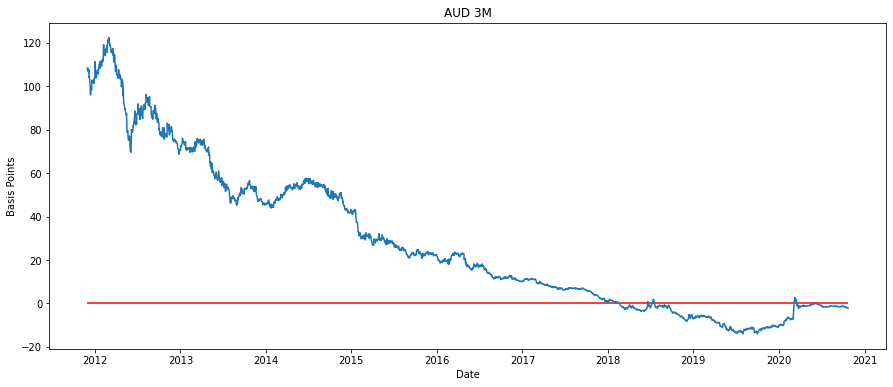

In [155]:
horizon = "3M"
currency = "AUD"
master3m = AUD[["Date",horizon]].merge(fx[["Date",currency,currency+horizon]], on = "Date")\
.merge(USD[["Date",horizon]], on = "Date", suffixes = [currency,"USD"])

plot_cip(master3m)
mean = np.round(np.mean(master3m["Deviation"]),2)
sd = np.round(np.std(master3m["Deviation"]),2)

print("Mean (sd) deviation in basis point =" + " "+ str(mean) +" (" + str(sd) +")")

My results are in quite a bit higher than Du et al.(2016) where they found mean (sd) deviation in AUD from 2010 to 2016 to be 5.3 (9.3), however I do not have data prior to 2012. Interestingly AUD 3M has approached parity since 2016.

In [156]:
master3m.tail(1)

,Date,3MAUD,AUD,AUD3M,3MUSD,ArtYield,Deviation
4124,2020-10-23,0.001159,1.401,3.14,0.00089,0.023598,-2.270754


Here 3MAUD is our 3M Australia interest rate, AUD is our spot exchange rate, AUD3M is our AUD 3M forward rate, 3MUSD is our 3M US interest rate, ArtYield is the yield recieved by swapping to a AUD, and deviation is (3MUSD - ArtYield) *100

Mean (sd) deviation in basis point = 1059.12 (871.39)


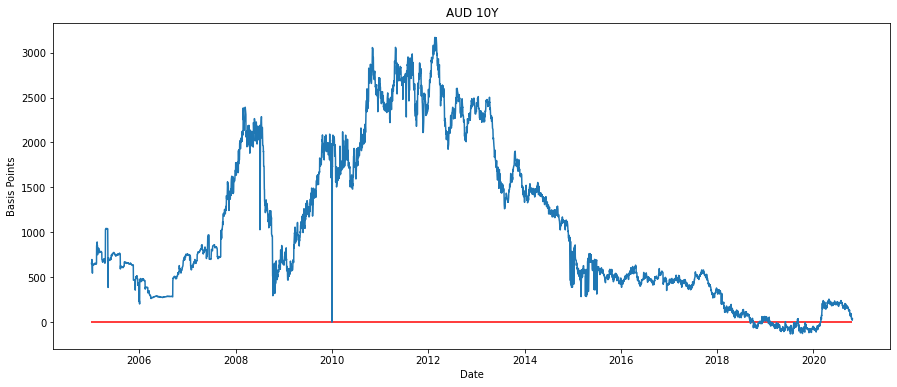

In [157]:
horizon = "10Y"
currency = "AUD"
master10y = AUD[["Date",horizon]].merge(fx[["Date",currency,currency+horizon]], on = "Date")\
.merge(USD[["Date",horizon]], on = "Date", suffixes = [currency,"USD"])

plot_cip(master10y)
mean = np.round(np.mean(master10y["Deviation"]),2)
sd = np.round(np.std(master10y["Deviation"]),2)

print("Mean (sd) deviation in basis point =" + " "+ str(mean) +" (" + str(sd) +")")

#### Eurozone

In [158]:
EUR = pd.read_csv(path+r"\EUR.csv")
to_date(EUR)
to_rate(EUR)

check_missing(EUR)

There are no missing values.

Mean (sd) deviation in basis point = -27.53 (46.82)


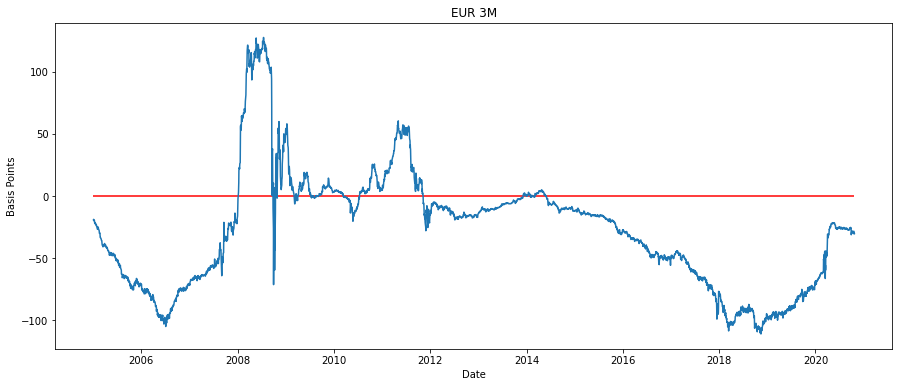

In [159]:
horizon = "3M"
currency = "EUR"
master3m = EUR[["Date",horizon]].merge(fx[["Date",currency,currency+horizon]], on = "Date")\
.merge(USD[["Date",horizon]], on = "Date", suffixes = [currency,"USD"])

plot_cip(master3m)
mean = np.round(np.mean(master3m["Deviation"]),2)
sd = np.round(np.std(master3m["Deviation"]),2)

print("Mean (sd) deviation in basis point =" + " "+ str(mean) +" (" + str(sd) +")")

My results are in in line with Du et al.(2016) where they found mean (sd) deviation in EUR from 2010 to 2016 to be -31.2 (25.3).

Mean (sd) deviation in basis point = -1742.61 (1108.61)


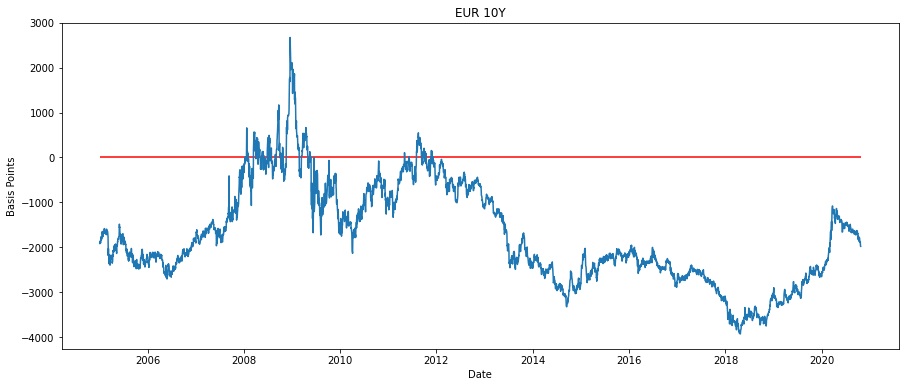

In [160]:
horizon = "10Y"
currency = "EUR"
master10y = EUR[["Date",horizon]].merge(fx[["Date",currency,currency+horizon]], on = "Date")\
.merge(USD[["Date",horizon]], on = "Date", suffixes = [currency,"USD"])

plot_cip(master10y)
mean = np.round(np.mean(master10y["Deviation"]),2)
sd = np.round(np.std(master10y["Deviation"]),2)

print("Mean (sd) deviation in basis point =" + " "+ str(mean) +" (" + str(sd) +")")

#### Japan

In [161]:
JPY = pd.read_csv(path+r"\JPY.csv")
to_date(JPY)
to_rate(JPY)

check_missing(JPY)

There are no missing values.

Mean (sd) deviation in basis point = 1.62 (1.93)


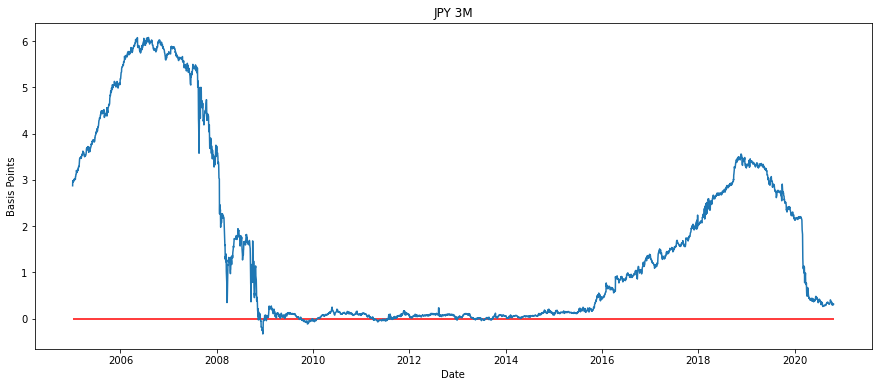

In [162]:
horizon = "3M"
currency = "JPY"
master3m = JPY[["Date",horizon]].merge(fx[["Date",currency,currency+horizon]], on = "Date")\
.merge(USD[["Date",horizon]], on = "Date", suffixes = [currency,"USD"])

plot_cip(master3m)
mean = np.round(np.mean(master3m["Deviation"]),2)
sd = np.round(np.std(master3m["Deviation"]),2)

print("Mean (sd) deviation in basis point =" + " "+ str(mean) +" (" + str(sd) +")")

My results are in quite a bit higher than Du et al.(2016) where they found mean (sd) deviation in JPY from 2010 to 2016 to be -24.6 (15.5). More interestingly there seems to be parity from 2009 to early 2016, this is not seen in any other literature, I will have to investigate what the data issue is here.

Mean (sd) deviation in basis point = 25.5 (5.02)


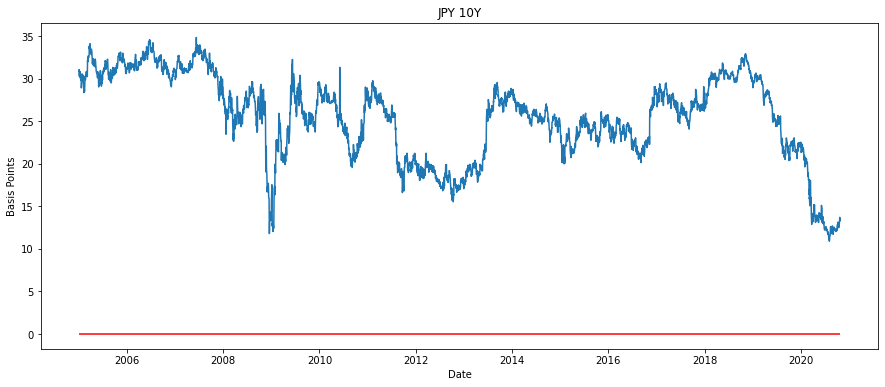

In [163]:
horizon = "10Y"
currency = "JPY"
master10y = JPY[["Date",horizon]].merge(fx[["Date",currency,currency+horizon]], on = "Date")\
.merge(USD[["Date",horizon]], on = "Date", suffixes = [currency,"USD"])

plot_cip(master10y)
mean = np.round(np.mean(master10y["Deviation"]),2)
sd = np.round(np.std(master10y["Deviation"]),2)

print("Mean (sd) deviation in basis point =" + " "+ str(mean) +" (" + str(sd) +")")

### Emerging Economies
Since we do not have 10 year forward rates, I will focus on the CIP deviation in the 3 month horizon.

#### South Korea

In [164]:
KRW = pd.read_csv(path+r"\KRW.csv")
to_date(KRW)
to_rate(KRW)

check_missing(KRW)

There are no missing values in the yield data, however note that there are no 10 year forward rate data.

Mean (sd) deviation in basis point = -2.45 (1.42)


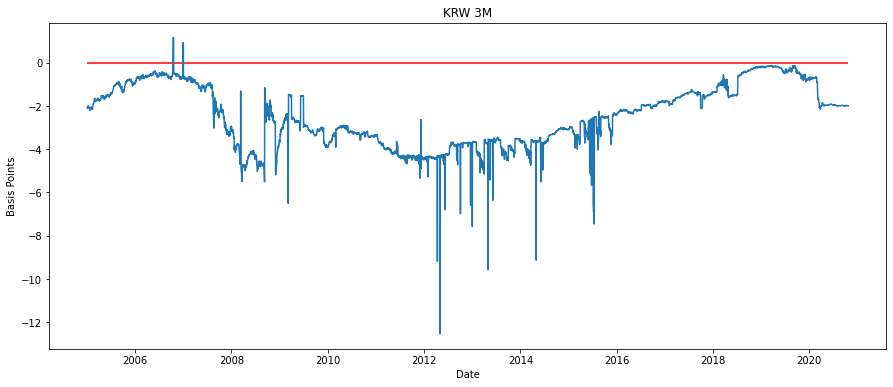

In [165]:
horizon = "3M"
currency = "KRW"
master3m = KRW[["Date",horizon]].merge(fx[["Date",currency,currency+horizon]], on = "Date")\
.merge(USD[["Date",horizon]], on = "Date", suffixes = [currency,"USD"])

plot_cip(master3m)
mean = np.round(np.mean(master3m["Deviation"]),2)
sd = np.round(np.std(master3m["Deviation"]),2)

print("Mean (sd) deviation in basis point =" + " "+ str(mean) +" (" + str(sd) +")")

#### India

In [166]:
INR = pd.read_csv(path+r"\INR.csv")
to_date(INR)
to_rate(INR)

check_missing(INR)

There are no missing values in the yield data, however note that there are no 10 year forward rate data.

Mean (sd) deviation in basis point = -6.44 (2.43)


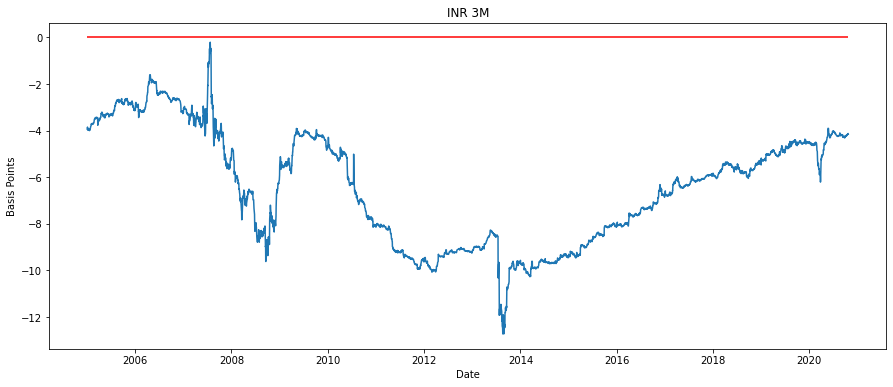

In [167]:
horizon = "3M"
currency = "INR"
master3m = INR[["Date",horizon]].merge(fx[["Date",currency,currency+horizon]], on = "Date")\
.merge(USD[["Date",horizon]], on = "Date", suffixes = [currency,"USD"])

plot_cip(master3m)
mean = np.round(np.mean(master3m["Deviation"]),2)
sd = np.round(np.std(master3m["Deviation"]),2)

print("Mean (sd) deviation in basis point =" + " "+ str(mean) +" (" + str(sd) +")")

#### Mexico

In [168]:
MXN = pd.read_csv(path+r"\MXN.csv")
to_date(MXN)
to_rate(MXN)

check_missing(MXN)

First non-null value in 10Y starts on 2005-09-27
First non-null value in 1Y starts on 2008-04-01


There are missing values in the 10 year and 1 year yield data, however note that there are no 10 year forward rate data.

Mean (sd) deviation in basis point = -114.86 (46.0)


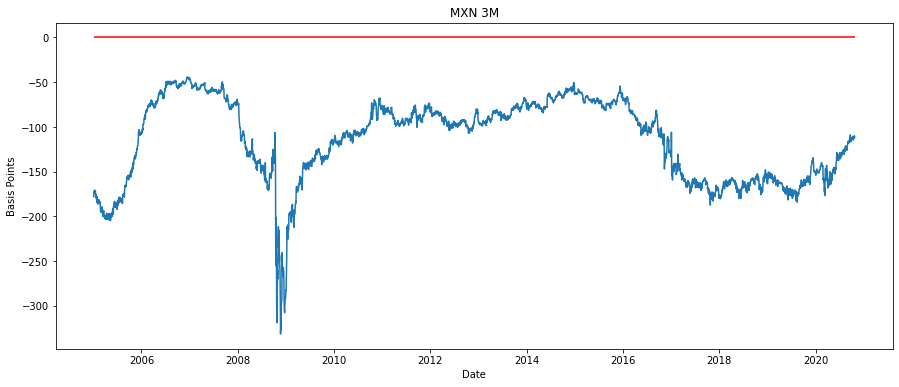

In [169]:
horizon = "3M"
currency = "MXN"
master3m = MXN[["Date",horizon]].merge(fx[["Date",currency,currency+horizon]], on = "Date")\
.merge(USD[["Date",horizon]], on = "Date", suffixes = [currency,"USD"])

plot_cip(master3m)
mean = np.round(np.mean(master3m["Deviation"]),2)
sd = np.round(np.std(master3m["Deviation"]),2)

print("Mean (sd) deviation in basis point =" + " "+ str(mean) +" (" + str(sd) +")")

### Conclusion
Just from a brief overview of the data, there is definitely a persistent deviation from CIP in the emerging market, from the three markets that were in this data exploration we can see all had negative CIP basis, indicating a relative cheapness in USD rates.

There still is a lot to be done, whereas my results so far are mostly in line with literature, I do not see the near parity condition that many literature found pre 2006, I may want to extend my historical data to the early 2000s, however it may be infeasible for some emerging countries. Furthermore, there seems to be data issuesin KRW 3M and JPY 3M that I will need to investigate. I have an idea to use 3 month bank deposit rate as a validation to make sure that my analysis is completely off due to data issues. The 10 year basis is inherently larger than 3 month and that make sense because in the long run we really need to incorporate the difference in expected inflation as well. And upon further investigation, most literature actually use 5 year as the right end of the yield curve, thus I will be using 5 year in the future as well.

### References  
  
Du, W., A. Tepper and A. Verdelhan, 2018. Deviations from Covered Interest Rate Parity.*The Journal of Finance*, Vol. LXXIII No. 3, pp. 915-957.  
Cerutti, E., M. Obstfeld and Z. Zhou, 2019. Covered Interest Parity Deviations: Macrofinancial Determinants. IMF Working Paper No. 19/14.  
Du, W., A. Tepper and A. Verdelhan, 2018. Deviations from Covered Interest Rate Parity. The Journal of Finance, Vol. LXXIII No. 3, pp. 915-957.  
Avdjiev, S., W. Du, C. Koch and H. Shin, 2017. The Dollar, Bank Leverage and the Deviation from Covered Interest Parity. BIS Working Papers No. 592.  
Liao, G.Y., 2016. Credit migration and covered interest rate parity. Working Paper. Harvard Business School.  
Hong, G., A. Oeking, K. Kang, C. Rhee, 2019. What Do Deviations from Covered Interest Parity and Higher FX Hedging Costs Mean for Asia? IMF Working Paper No. 19/169.  
Hartley, J.S., 2020. Covered Interest Rate Parity Deviations in External Emerging Market Sovereign Debt. *The Journal of Fixed Income*, Vol. XXIX Issue 4, pp. 92-99.  
Rime, D., Schrimpf, A., Syrstad, O., 2017. Segmented money markets and covered interest party arbitrage. Working paper. Bank of International Settlements.
